<h3 
    align="center" 
    style="font-size: 35px; padding:20px; font-family:Georgia; text-align:center; display:block; border-radius:20px;background-color:#454545">
    <span style="color: white;">  🚢 Titanic Survival Prediction 🚢 </span>
</h3>

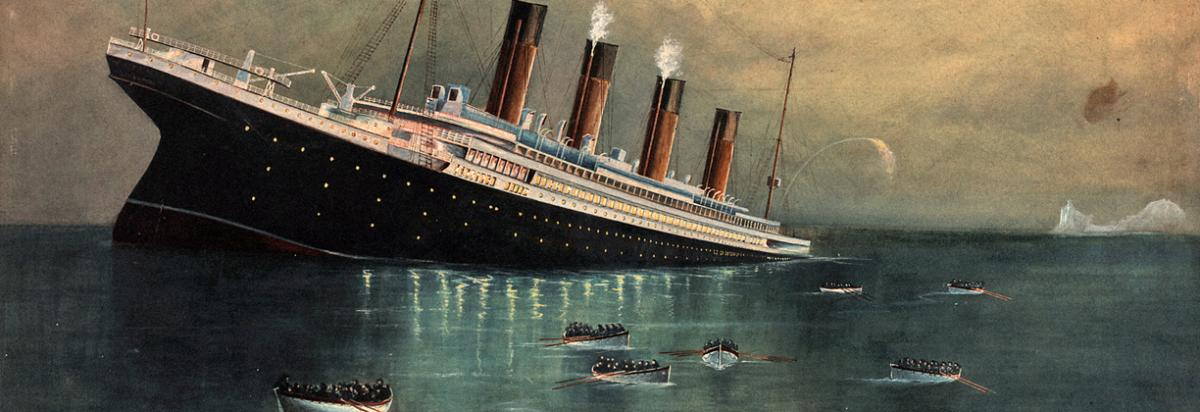

<h3 
    align="center" 
    style="font-size: 35px; padding:20px; font-family:Georgia; text-align:center; display:block; border-radius:20px;background-color:#454545">
    <span style="color: white;">📚 Importing Libraries 📚 </span>
</h3>

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

<h3 
    align="center" 
    style="font-size: 35px; padding:20px; font-family:Georgia; text-align:center; display:block; border-radius:20px;background-color:#454545">
    <span style="color: white;">⏳ Loading the dataset ⏳</span>
</h3>

In [ ]:
titanic = pd.read_csv('/kaggle/input/test-file/tested.csv')

<h3 
    align="center" 
    style="font-size: 35px; padding:20px; font-family:Georgia; text-align:center; display:block; border-radius:20px;background-color:#454545">
    <span style="color: white;">🧠 Understanding of data 🧠</span>
</h3>

In [ ]:
titanic.head()

In [ ]:
titanic.info()

<h3 
    align="center" 
    style="font-size: 35px; padding:20px; font-family:Georgia; text-align:center; display:block; border-radius:20px;background-color:#454545">
    <span style="color: white;">🧹 Data Cleaning 🧹</span>
</h3>

In [ ]:
# Checking null values

titanic.isna().sum()

In [ ]:
# Handling the null values 

columns = ['Age', 'Fare']
for col in columns:
    titanic[col].fillna(titanic[col].median(), inplace = True)
    
titanic['Cabin'].fillna('Unknown', inplace=True)

In [ ]:
#checking duplicate values

dup = titanic.duplicated().sum()
print("The number of duplicated values in the dataset are: ", dup)

In [ ]:
#Checking if there are any typos

for col in titanic.select_dtypes(include = "object"):
    print(f"Name of Column: {col}")
    print(titanic[col].unique())
    print('\n', '-'*60, '\n')

<div style="border-radius:10px; border:#000000 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<h3 align="left"><font color=black>📊 Insights:</font></h3>

* The following columns: **Age, Fare, and Cabin had null values** in the dataset
* The null values in **Age and Fare** column were filled with **median** instead of mean due to the presence of outliers
* The null values in **Cabin** column were filled with **Unknown**
* Later, we checked the unique values inside **Categorical Columns** to see if there are any **typos or useful information**

<h3 
    align="center" 
    style="font-size: 35px; padding:20px; font-family:Georgia; text-align:center; display:block; border-radius:20px;background-color:#454545">
    <span style="color: white;">🔎 Feature Engineering 🔎</span>
</h3>

In [ ]:
titanic.head()

In [ ]:
# Creating a new feature of title from name column based on the pattern found above

titanic['Title'] = titanic['Name'].str.extract(r',\s(.*?)\.')

titanic['Title'] = titanic['Title'].replace('Ms', 'Miss')
titanic['Title'] = titanic['Title'].replace('Dona', 'Mrs')
titanic['Title'] = titanic['Title'].replace(['Col', 'Rev', 'Dr'], 'Rare')

In [ ]:
# Creating another feature of Age group by making bins

bins = [-np.inf, 17, 32, 45, 50, np.inf]
labels = ["Children", "Young", "Mid-Aged", "Senior-Adult", 'Elderly']
titanic['Age_Group'] = pd.cut(titanic['Age'], bins = bins, labels = labels)

In [ ]:
# Generting another new feature of family size 

titanic['Family'] = titanic['SibSp'] + titanic['Parch']

In [ ]:
# Dropping non essential coclumns

titanic.drop(['PassengerId', 'Name', 'Ticket'], axis = 1, inplace = True)

In [ ]:
titanic.head()

In [ ]:
# Chaning the positon of columns to place them right after their parent column

col_to_move = titanic.pop('Age_Group')
titanic.insert(4, 'Age_Group', col_to_move)

col_to_move = titanic.pop('Family')
titanic.insert(7, 'Family', col_to_move)

titanic['Age_Group'] = titanic['Age_Group'].astype('object')

<div style="border-radius:10px; border:#000000 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<h3 align="left"><font color=black>📊 Insights:</font></h3>

* Following of the 3 new features were created: **Title, Age_Group, and Family**
* Next, **positions** of these new columns were changed and their **data type** as well

<h3 
    align="center" 
    style="font-size: 35px; padding:20px; font-family:Georgia; text-align:center; display:block; border-radius:20px;background-color:#454545">
    <span style="color: white;">📊 Exploratory Data Analysis 📊</span>
</h3>

---
### Descriptive Analysis
---

In [ ]:
titanic.describe()

In [ ]:
titanic.describe(include = 'O')

In [ ]:
titanic.groupby('Sex')[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Family', 'Fare']].mean()

In [ ]:
titanic.groupby('Embarked')[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Family', 'Fare']].mean()

<div style="border-radius:10px; border:#000000 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<h3 align="left"><font color=black>📊 Insights:</font></h3>

* The analysis revealed that mostly people are: **Young male who have traveled more Southampton**
* **Females** are more likely to travel with someone and pay high fares
* Furthermore, people embarked from **Cherbourg** have an **average age of 33 and fares to pay around 66 pounds**

---
### Univariate Analysis
---

In [ ]:
survived_counts = titanic['Survived'].value_counts()
fig_surv_perc = px.pie(titanic, names= survived_counts.index,  values = survived_counts.values, title=f'Distribution of Survived', hole=0.2, color_discrete_sequence=px.colors.sequential.Viridis)
fig_surv_perc.update_traces(textinfo='percent+label')
fig_surv_perc.update_layout(legend_title_text='Categories:', legend=dict(orientation="h", yanchor="bottom", y=1.02))
fig_surv_perc.show()

In [ ]:
pclass_counts = titanic.Pclass.value_counts()
fig_pclass_perc = px.pie(titanic, names= pclass_counts.index, values = pclass_counts.values, title=f'Distribution of Pclass', hole=0.2, color_discrete_sequence=px.colors.sequential.Viridis)
fig_pclass_perc.update_traces(textinfo='percent+label')
fig_pclass_perc.update_layout(legend_title_text='Categories:', legend=dict(orientation="h", yanchor="bottom", y=1.02))
fig_pclass_perc.show()

In [ ]:
fig_sex_count = px.histogram(titanic, x = 'Sex', color = 'Sex', color_discrete_sequence=px.colors.sequential.Viridis)
fig_sex_count.update_layout(title_text='Count of different Sex', xaxis_title='Sex', yaxis_title='Count', plot_bgcolor = 'white')
fig_sex_count.show()

fig_sex_perc = px.pie(titanic, names= 'Sex', title=f'Distribution of Sex', hole=0.2, color_discrete_sequence=px.colors.sequential.Viridis)
fig_sex_perc.update_traces(textinfo='percent+label')
fig_sex_perc.update_layout(legend_title_text='Categories:', legend=dict(orientation="h", yanchor="bottom", y=1.02))
fig_sex_perc.show()

In [ ]:
fig_age = px.histogram(titanic, x='Age', nbins=30, histnorm='probability density')
fig_age.update_traces(marker=dict(color='#440154'), selector=dict(type='histogram'))
fig_age.update_layout(title='Distribution of Age', title_x=0.5, title_pad=dict(t=20), title_font=dict(size=20), xaxis_title='Age', yaxis_title='Probability Density', xaxis=dict(showgrid=False), yaxis=dict(showgrid=False), bargap=0.02, plot_bgcolor = 'white')
fig_age.show()

In [ ]:
fig_fare = px.histogram(titanic, x='Fare', nbins=30, histnorm='probability density')
fig_fare.update_traces(marker=dict(color='#440154'), selector=dict(type='histogram'))
fig_fare.update_layout(title='Distribution of Fare', title_x=0.5, title_pad=dict(t=20), title_font=dict(size=20), xaxis_title='Fare', yaxis_title='Probability Density', xaxis=dict(showgrid=False), yaxis=dict(showgrid=False), bargap=0.02, plot_bgcolor = 'white')
fig_fare.show()

In [ ]:
fig_embarked_count = px.histogram(titanic, x = 'Embarked', color = 'Embarked', color_discrete_sequence=px.colors.sequential.Viridis)
fig_embarked_count.update_layout(title_text='Count of different Embarked', xaxis_title='Embarked', yaxis_title='Count', plot_bgcolor = 'white')
fig_embarked_count.show()

fig_embarked_perc = px.pie(titanic, names= 'Embarked', title=f'Distribution of Embarked', hole=0.2, color_discrete_sequence=px.colors.sequential.Viridis)
fig_embarked_perc.update_traces(textinfo='percent+label')
fig_embarked_perc.update_layout(legend_title_text='Categories:', legend=dict(orientation="h", yanchor="bottom", y=1.02))
fig_embarked_perc.show()

In [ ]:
fig_title_count = px.histogram(titanic, x = 'Title', color = 'Title', color_discrete_sequence=px.colors.sequential.Viridis)
fig_title_count.update_layout(title_text='Count of different Title', xaxis_title='Title', yaxis_title='Count', plot_bgcolor = 'white')
fig_title_count.show()

fig_title_perc = px.pie(titanic, names= 'Title', title=f'Distribution of Title', hole=0.2, color_discrete_sequence=px.colors.sequential.Viridis)
fig_title_perc.update_traces(textinfo='percent+label')
fig_title_perc.update_layout(legend_title_text='Categories:', legend=dict(orientation="h", yanchor="bottom", y=1.02))
fig_title_perc.show()

<div style="border-radius:10px; border:#000000 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<h3 align="left"><font color=black>📊 Insights:</font></h3>

* Only **36.4% of the people** survived the crash 
    
* The dataset also have a high distribution of poeple from **Pclass = 3**, and **high ratio of males**
    
* The distribution of age is centered around **25-29**, and fare is around **10-30**
    
* Most of the people are **embarked from Southampton**, and mostly the title holded by passengers are **Mr. = Single Male**

---
### Bivariate Analysis
---

In [ ]:
fig_pclass_surv = px.histogram(titanic, x = 'Pclass', barmode = 'group', color = 'Survived', color_discrete_sequence=px.colors.sequential.Viridis)
fig_pclass_surv.update_layout(title = 'Survival according to passenger classes', plot_bgcolor = 'white')
fig_pclass_surv.show()

In [ ]:
fig_pclass_surv = px.histogram(titanic, x = 'Sex', barmode = 'group', color = 'Survived', color_discrete_sequence=px.colors.sequential.Viridis)
fig_pclass_surv.update_layout(title = 'Survival according to gender', plot_bgcolor = 'white')
fig_pclass_surv.show()

In [ ]:
fig_embarked_surv = px.histogram(titanic, x = 'Age_Group', barmode = 'group', color = 'Survived', color_discrete_sequence=px.colors.sequential.Viridis)
fig_embarked_surv.update_layout(title = 'Survival according to age groups', plot_bgcolor = 'white')
fig_embarked_surv.show()

In [ ]:
fig_family_surv = px.histogram(titanic, x = 'Family', barmode = 'group', color = 'Survived', color_discrete_sequence=px.colors.sequential.Viridis)
fig_family_surv.update_layout(title = 'Survival according to number of family members', plot_bgcolor = 'white')
fig_family_surv.show()

In [ ]:
fig_embarked_surv = px.histogram(titanic, x = 'Embarked', barmode = 'group', color = 'Survived', color_discrete_sequence=px.colors.sequential.Viridis)
fig_embarked_surv.update_layout(title = 'Survival according to embarked', plot_bgcolor = 'white')
fig_embarked_surv.show()

<div style="border-radius:10px; border:#000000 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<h3 align="left"><font color=black>📊 Insights:</font></h3>

* The least deaths are from **Pclass = 1** and the highest number of deaths are from **Pclass = 3**
    
* The dataset also have a high distribution of poeple from **Pclass = 3**, and **high ratio of males**
    
* **None of the male survived**, and all the **females survived**
    
* The highest death count is from **Young Age Group**, and **Elderly People** have a good survival count

* Poeple with **few family members** are more likely to survive according to analysis
    
* A high ratio of poeple who **embarked from Queenstown survived**, and **Southampton** has the highest death casualities

---
### Multivariate Analysis
---

In [ ]:
grouped_data = titanic.groupby(['Age', 'Sex', 'Survived']).agg({'Fare': 'mean'}).reset_index()
fig = px.line(grouped_data, x='Age', y='Fare', color='Survived', facet_col='Sex', facet_col_wrap=2, labels={'Fare': 'Fare', 'Survived': 'Survived'}, title='12. Relation of age and gender with fare')

fig.update_layout(hovermode='x unified', plot_bgcolor = 'white')
fig.update_xaxes(title_text='Age')
fig.update_yaxes(title_text='Fair', row=1, col=1)
fig.show()

<div style="border-radius:10px; border:#000000 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<h3 align="left"><font color=black>📊 Insights:</font></h3>

* The analysis revealed that **Fare is a bit high for females compared to males**, and the **Fare is likely to increase according to Age for females**. Overall, **Age doesn't have a significant impact on survival**

<h3 
    align="center" 
    style="font-size: 35px; padding:20px; font-family:Georgia; text-align:center; display:block; border-radius:20px;background-color:#454545">
    <span style="color: white;">⚙️ Data Preprocessing ⚙️</span>
</h3>

---
### 1. Label Encoding
---

In [ ]:
# Labeling the ordinal variables

le = LabelEncoder()
cols = ['Sex', 'Age_Group', 'Cabin', 'Embarked', 'Title']

for col in cols:
    titanic[col] = le.fit_transform(titanic[col])

---
### 2. Class Imbalance
---

In [ ]:
# Checking the class count for target variable

titanic.Survived.value_counts()

In [ ]:
X = titanic.drop('Survived', axis = 1)
y = titanic['Survived']

In [ ]:
# Using the SMOTE technique to handle class imbalance

smote = SMOTE(random_state = 42)
X_balanced, y_balanced = smote.fit_resample(X, y)

---
### 3. Splitting into training and testing
---

In [ ]:
# Splitting the dataset into training and testing parts

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size = 0.3, random_state = 42) 

---
### 4. Feature Scaling
---

In [ ]:
# Doing feature scaling by StandardScaler

sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

<h3 
    align="center" 
    style="font-size: 35px; padding:20px; font-family:Georgia; text-align:center; display:block; border-radius:20px;background-color:#454545">
    <span style="color: white;">🎯 Model Building 🎯 </span>
</h3>

In [ ]:
# Building the models

lr = LogisticRegression()
rf = RandomForestClassifier()
gbc = GradientBoostingClassifier()

lr.fit(X_train_scaled, y_train)
rf.fit(X_train_scaled, y_train)
gbc.fit(X_train_scaled, y_train)

lr_pred = lr.predict(X_test_scaled)
rf_pred = rf.predict(X_test_scaled)
gbc_pred = gbc.predict(X_test_scaled)

<h3 
    align="center" 
    style="font-size: 35px; padding:20px; font-family:Georgia; text-align:center; display:block; border-radius:20px;background-color:#454545">
    <span style="color: white;">⚡ Model Evaluation ⚡ </span>
</h3>

In [ ]:
# Evaluating the models by generating classification report and cross validation scores

lr_report = classification_report(y_test, lr_pred)
lr_scores = cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='accuracy')

rf_report = classification_report(y_test, rf_pred)
rf_scores = cross_val_score(rf, X_train_scaled, y_train, cv=5, scoring='accuracy')

gbc_report = classification_report(y_test, gbc_pred)
gbc_scores = cross_val_score(gbc, X_train_scaled, y_train, cv=5, scoring='accuracy')


print('The classification report of Logistic Regression is below : ', '\n\n\n', lr_report)
print(f"Logistic Regression Mean Cross-Validation Score: {lr_scores}")

print('\n', '='*100, '\n')
print('The classification report of Random Forest is below : ', '\n\n\n', rf_report)
print(f"Random Forest Mean Cross-Validation Score: {rf_scores}")

print('\n', '='*100, '\n')
print('The classification report of Gradient Bossting Classifier is below : ', '\n\n\n', rf_report)
print(f"Gradient Boosting Classifier Mean Cross-Validation Score: {gbc_scores}")

<h3 
    align="center" 
    style="font-size: 35px; padding:20px; font-family:Georgia; text-align:center; display:block; border-radius:20px;background-color:#454545">
    <span style="color: white;">🎈 Conclusion 🎈 </span>
</h3>

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<h3 align="left"><font color=black>Conclusion:</font></h3>
    
---    
In this Titanic Survival Prediction analysis, we have explored various aspects of the dataset to understand the factors influencing survival. We found that only 36.4% of the passengers survived the crash, with significant differences in survival rates among different passenger classes, genders, and age groups. The dataset also revealed that certain features, such as Fare and embarkation location, played a role in survival. We trained several classification models to predict survival, all of which performed well, likely due to the relatively small dataset size.

 ---   
**Insights:**
         
    
Our analysis unveiled key insights into the Titanic dataset. We addressed missing values by filling null entries in the Age and Fare columns with medians due to the presence of outliers, while the Cabin column was filled with "Unknown." New features, including Title, Age_Group, and Family, were created to enhance our understanding of passenger demographics. We discovered that young males traveling from Southampton constituted the majority, and females were more likely to travel with others and pay higher fares. Notably, passengers from Cherbourg had an average age of 33 and paid around 66 pounds in fares. Furthermore, we observed that Pclass 3 had the highest number of deaths, with no surviving males and all females surviving. Family size appeared to influence survival, and passengers from Queenstown had a higher survival rate compared to those from Southampton.

---    
    
**What's next?** 
    
For future analysis, it would be beneficial to explore more advanced machine learning techniques and consider feature engineering to improve model performance further. Additionally, investigating the impact of other variables not included in this analysis, such as cabin location and passenger demographics beyond age, gender, and family size, could provide deeper insights. Further exploration of the dataset and refining models could enhance our ability to predict Titanic passenger survival more accurately.
    
---

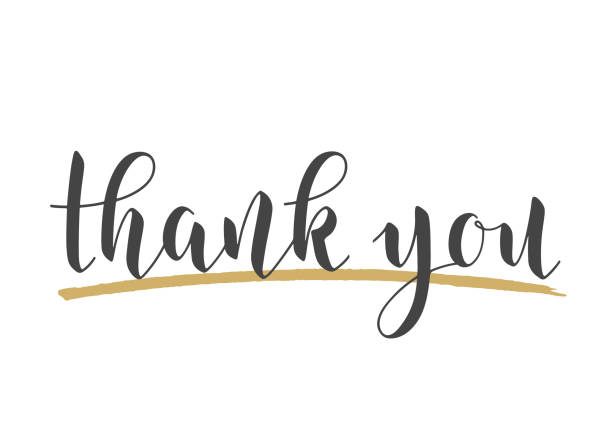